# Generate Masks

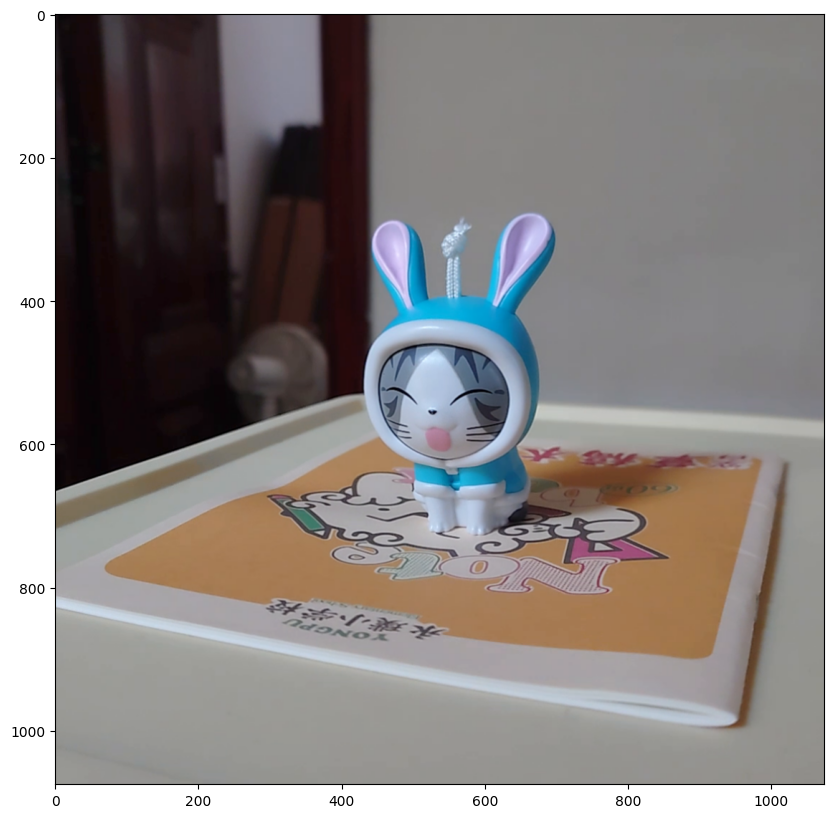

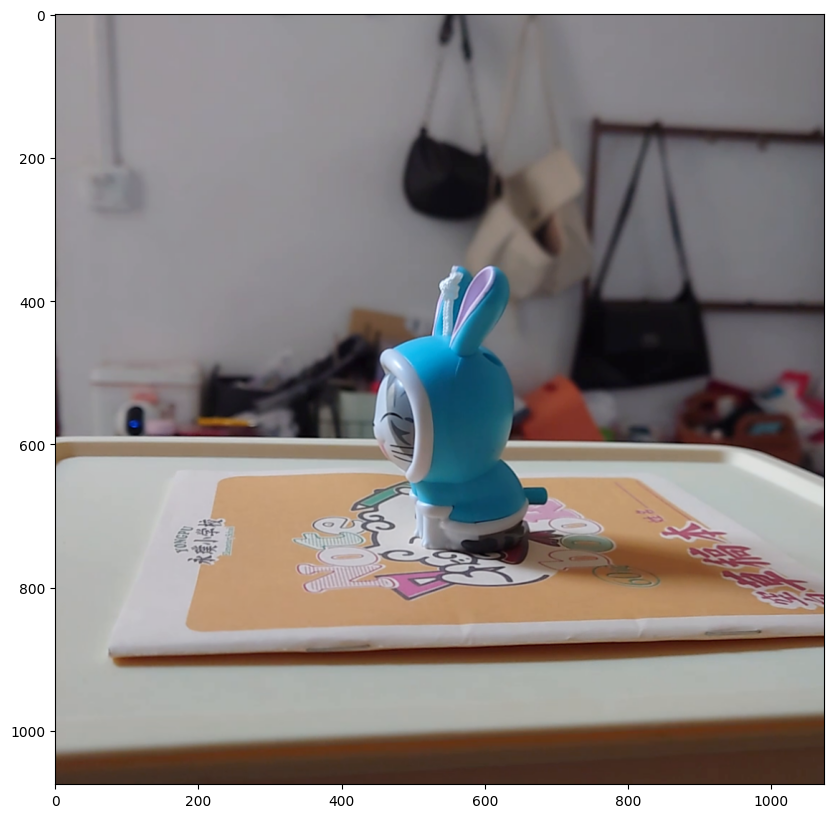

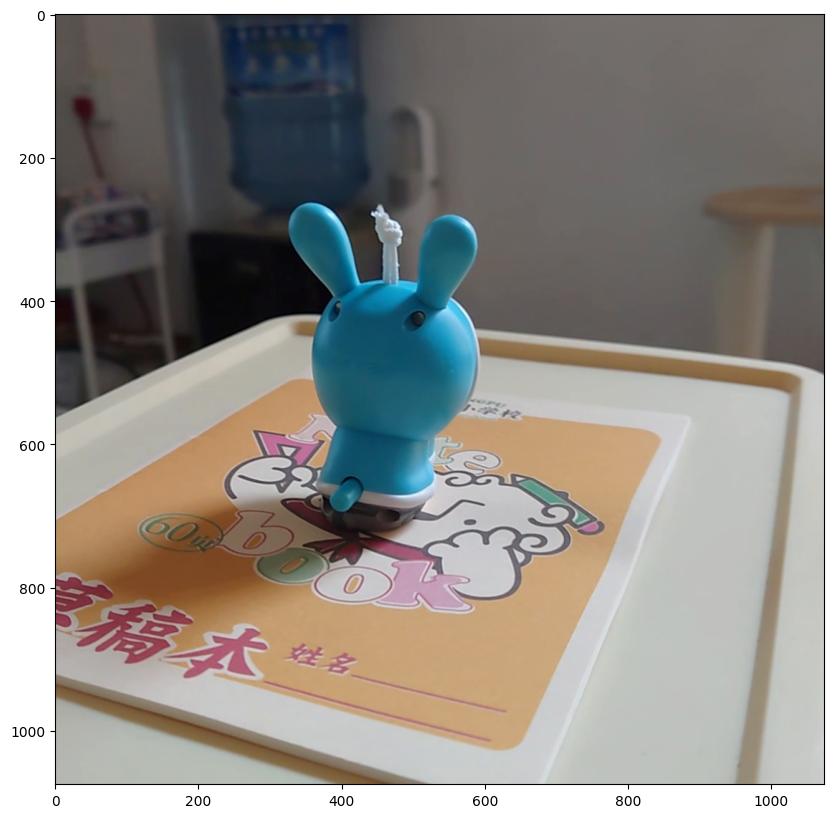

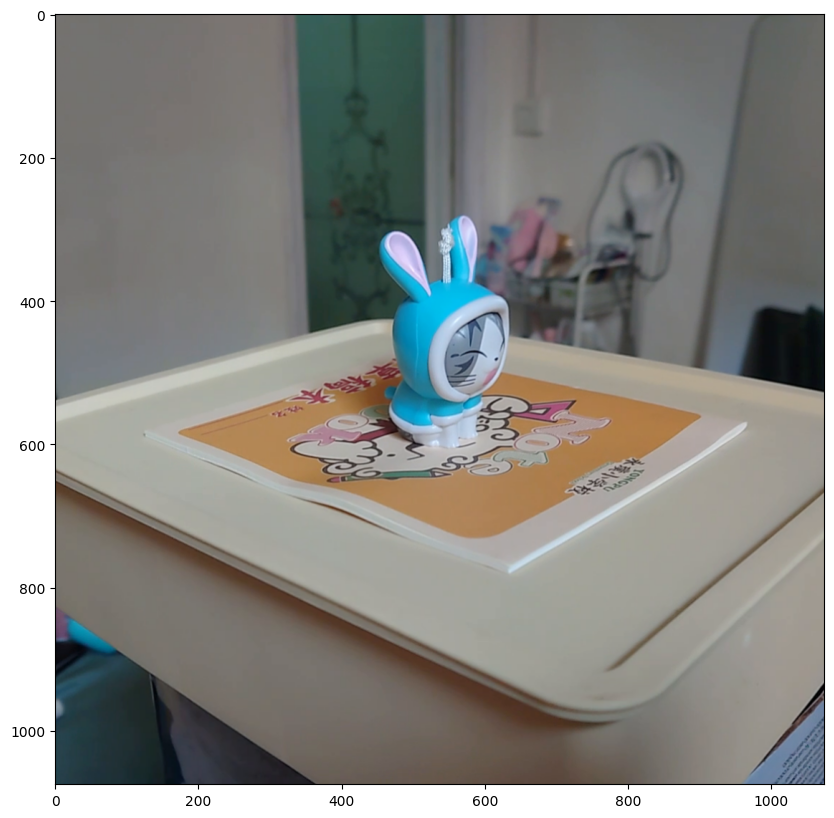

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

data_path = 'data/realcap/rabbit'
sparse_num = 4
image_path = os.path.join(data_path, 'images')
sparse_ids = np.loadtxt(os.path.join(data_path, f'sparse_{sparse_num}.txt'), dtype=np.int32)
image_names = [name for idx, name in enumerate(sorted(os.listdir(image_path))) if idx in sparse_ids]
images = [cv2.cvtColor(cv2.imread(os.path.join(image_path, image_name)), cv2.COLOR_BGR2RGB) for image_name in image_names]
for image in images:
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    plt.axis('on')
    plt.show()

In [2]:
input_points = [
    [[600, 600]],
    [[600, 600]],
    [[400, 600]],
    [[550, 500]]
]

In [3]:
from segment_anything import SamPredictor, sam_model_registry

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

sam = sam_model_registry["default"](checkpoint="models/sam_vit_h_4b8939.pth")
sam = sam.cuda()
predictor = SamPredictor(sam)

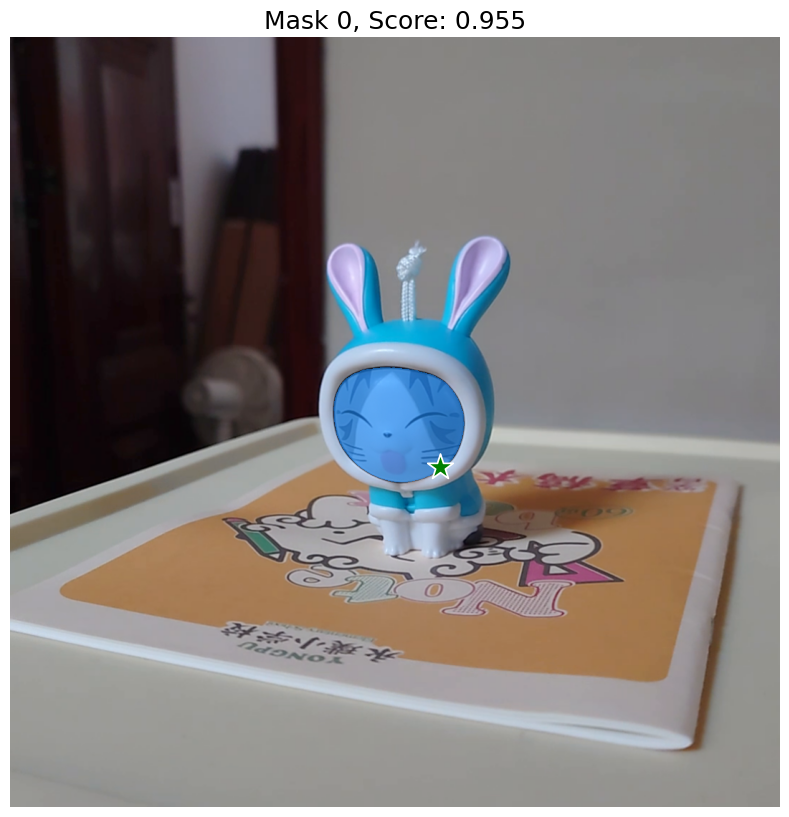

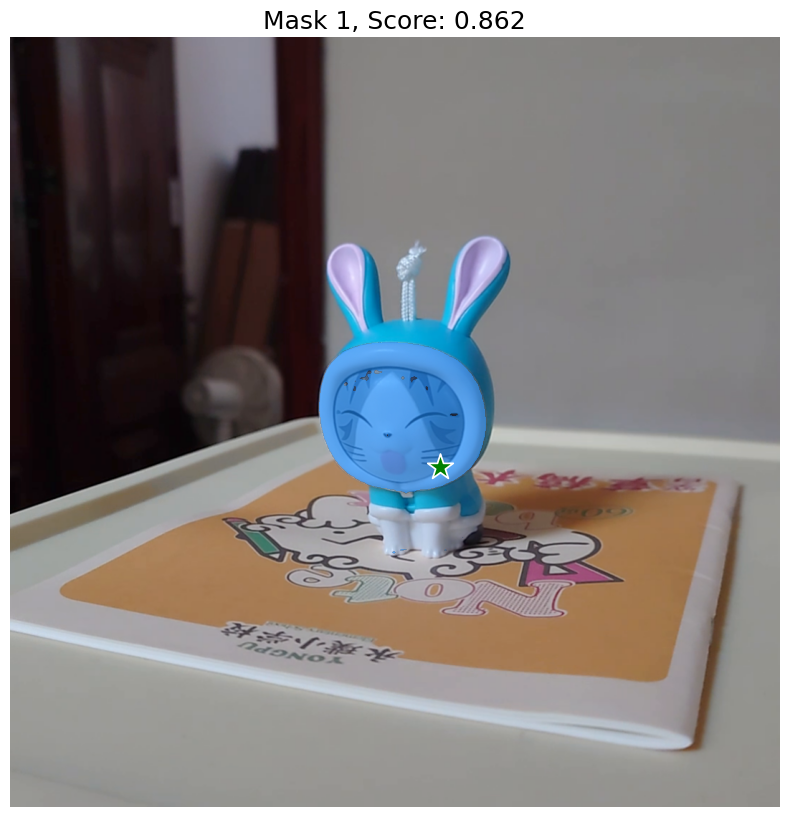

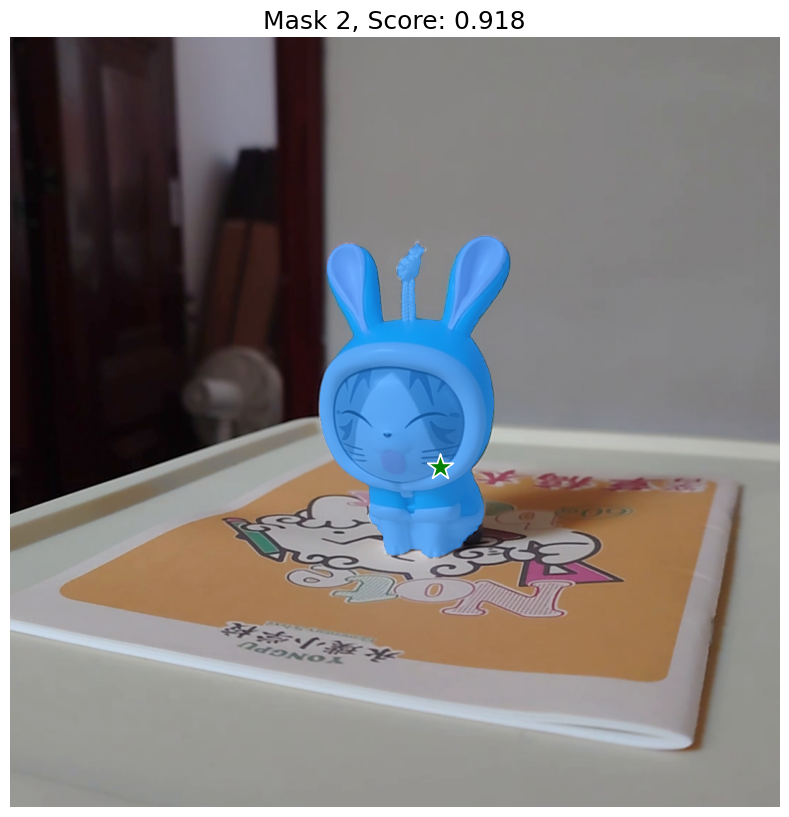

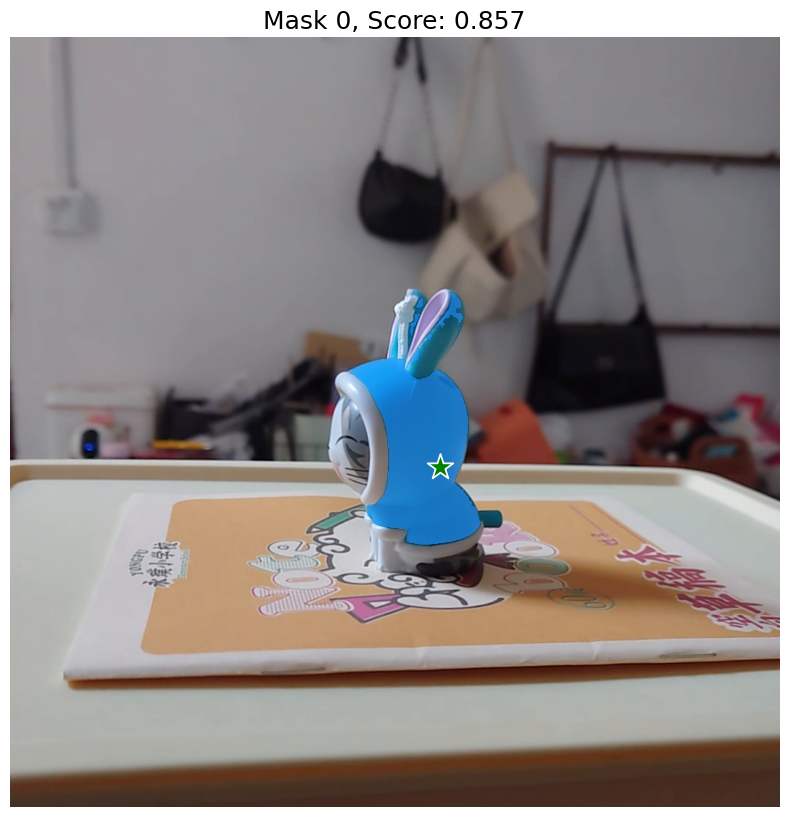

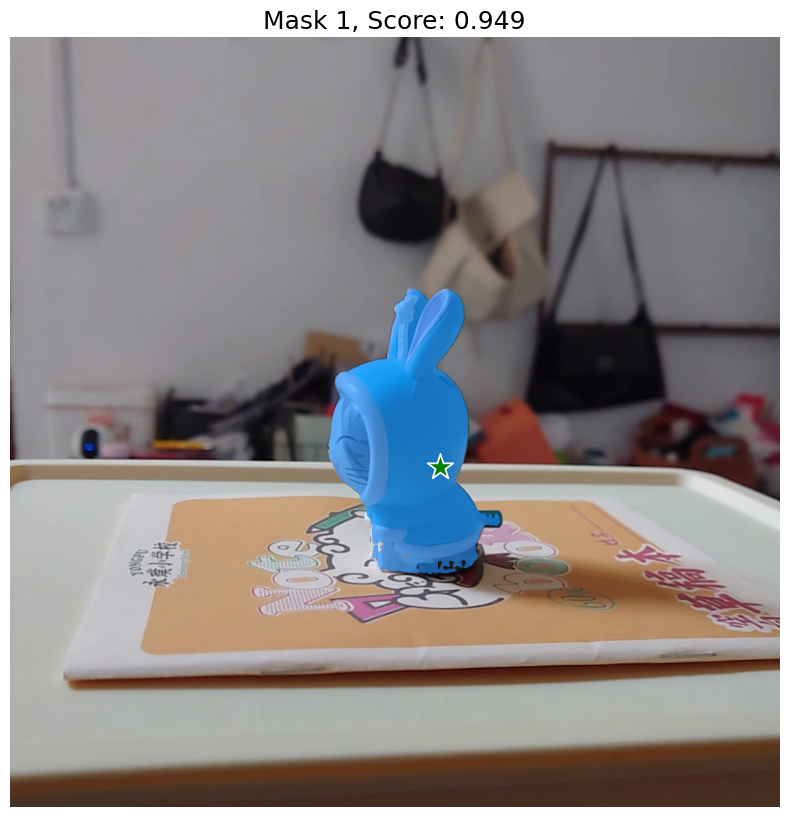

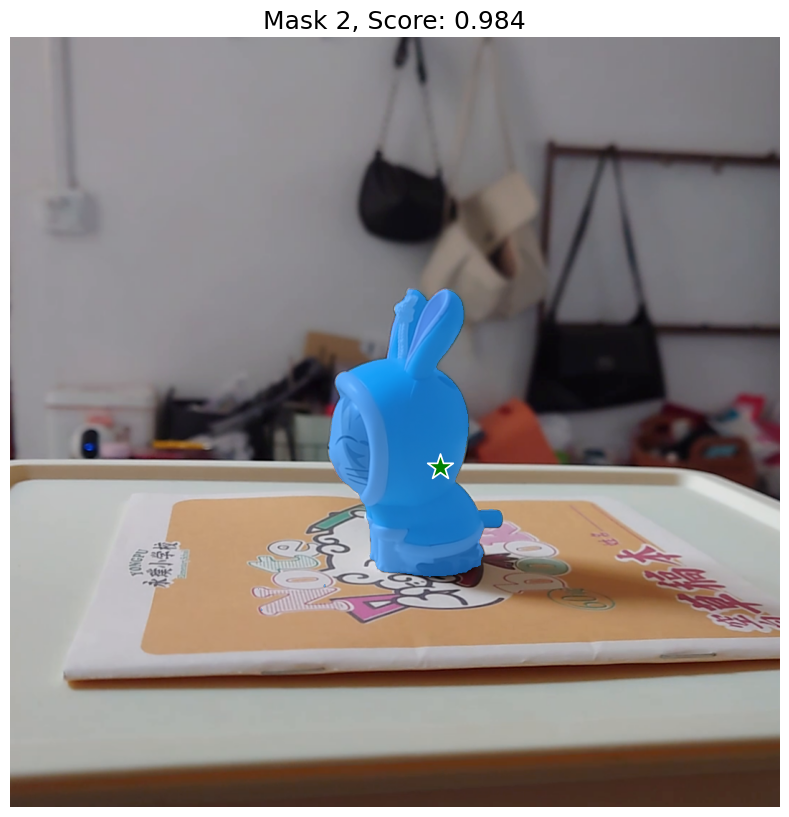

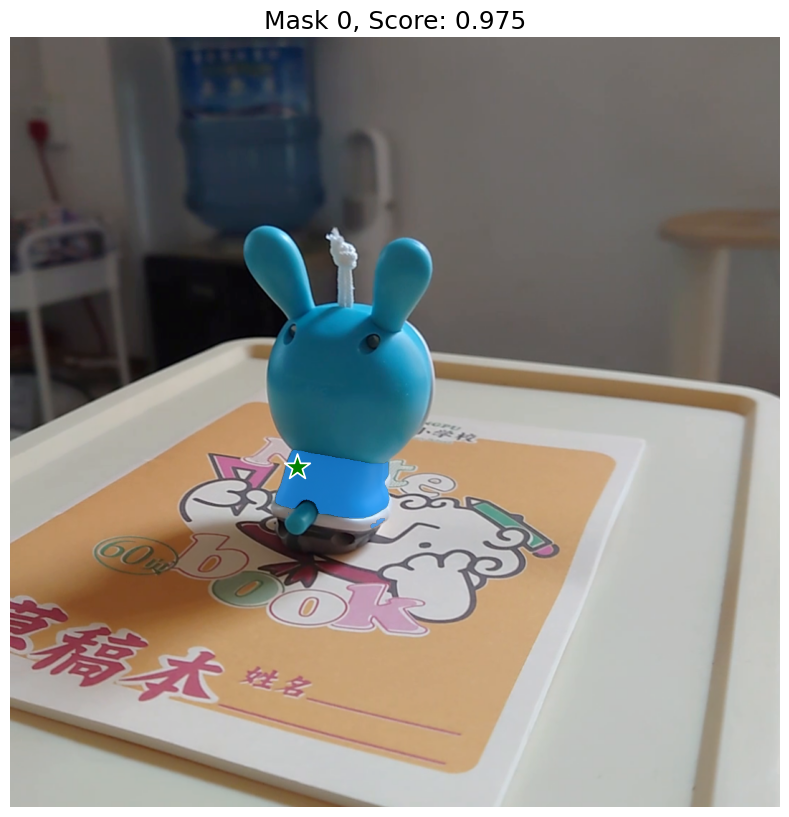

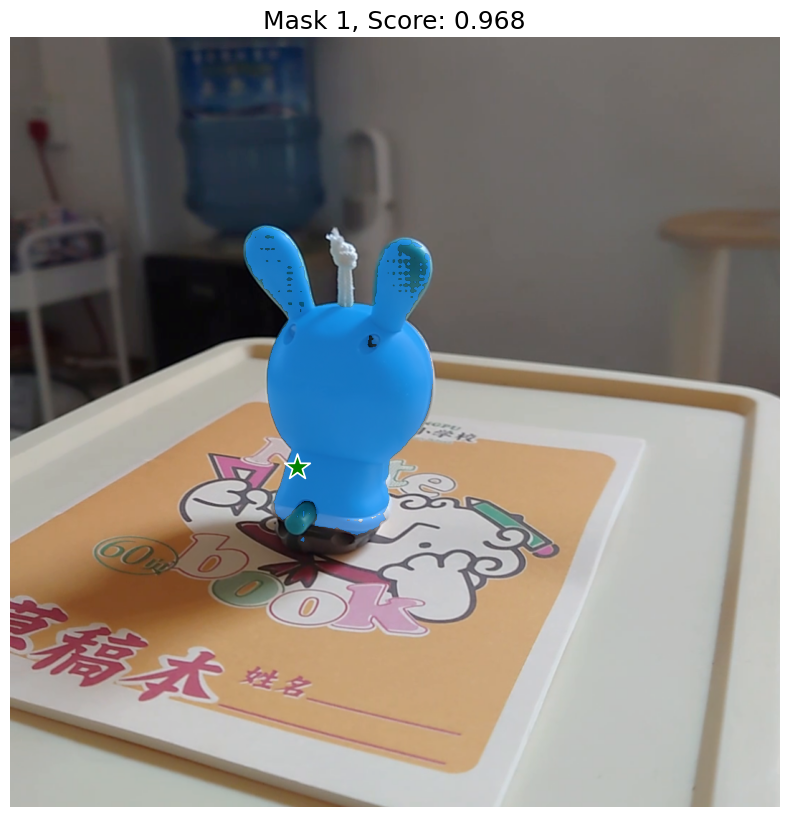

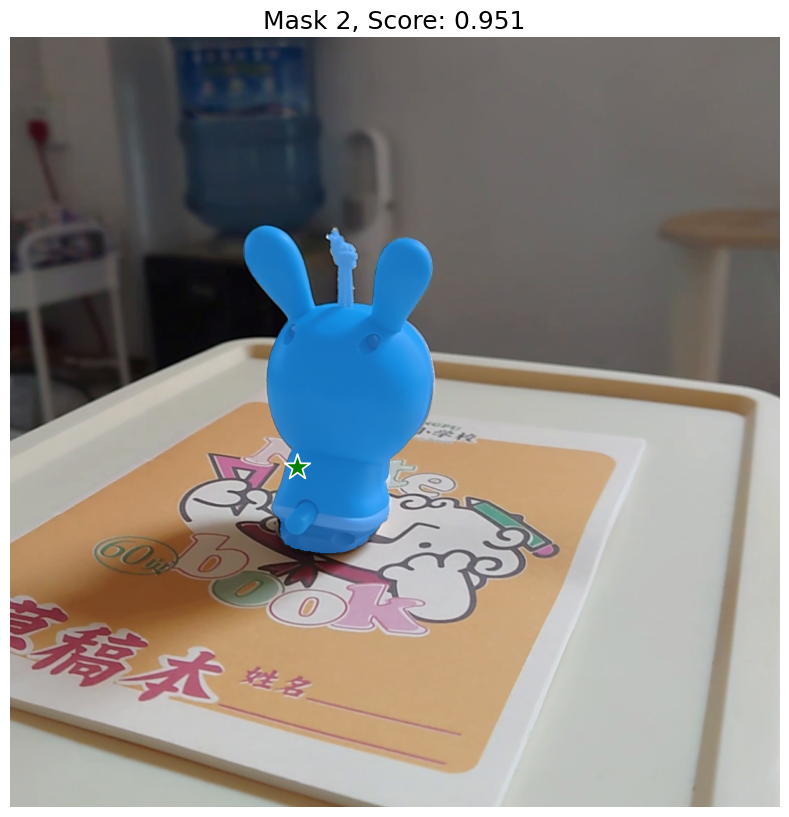

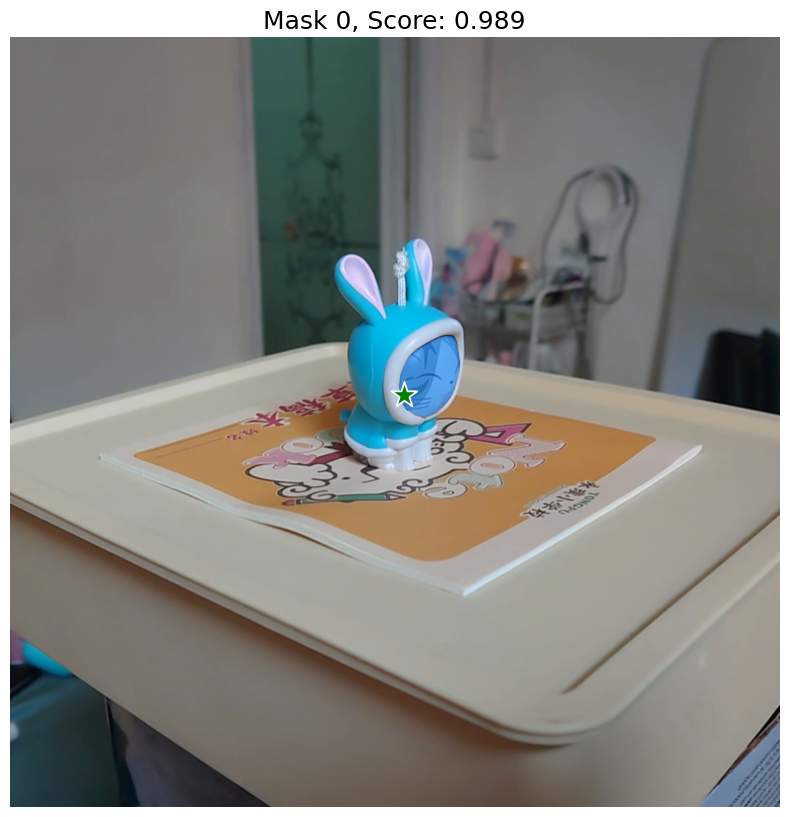

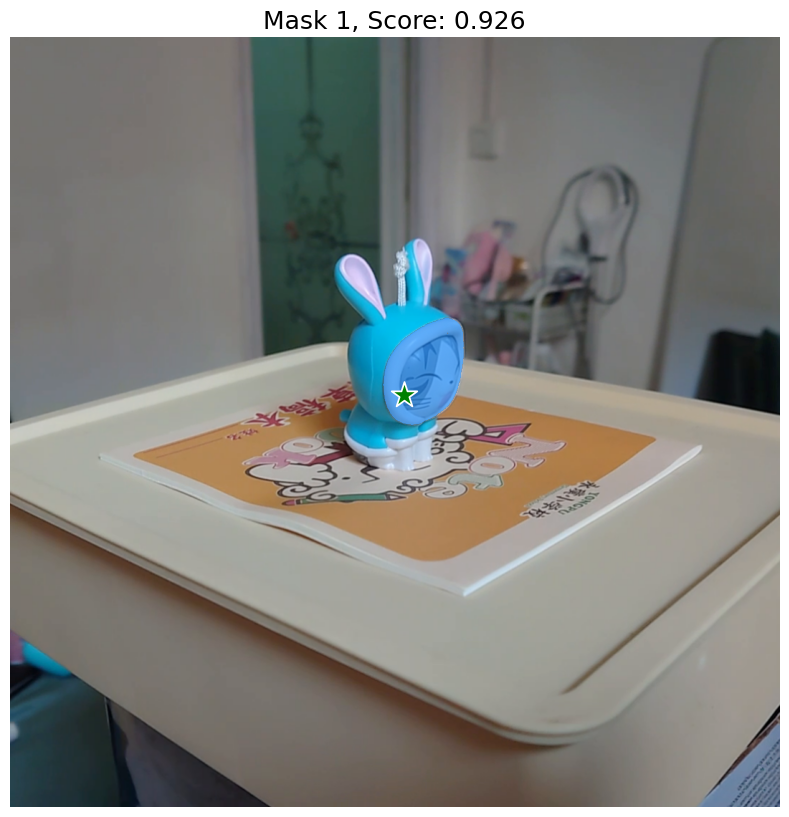

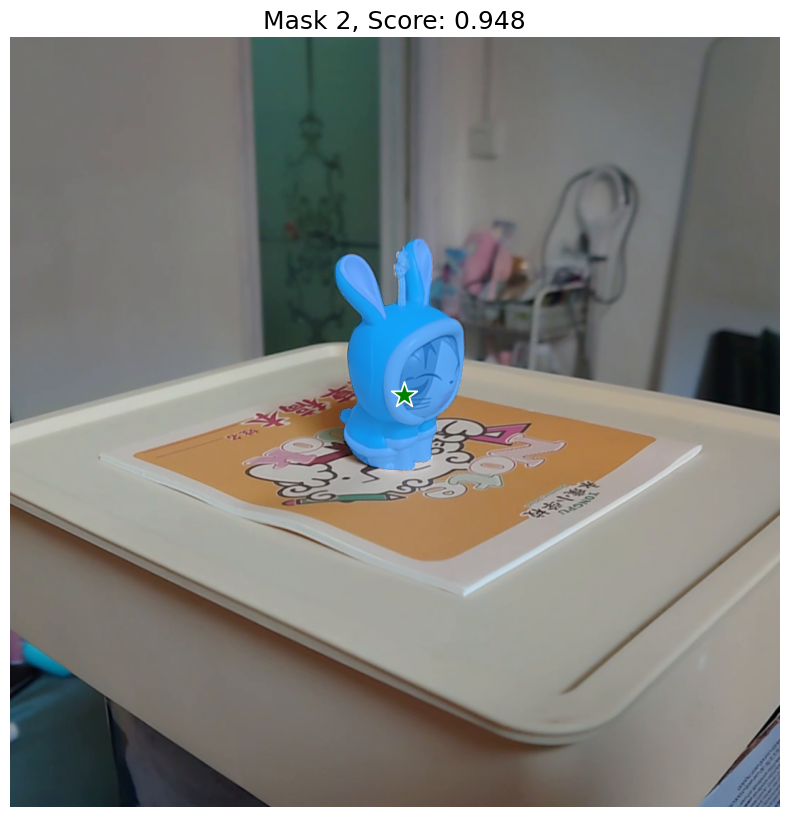

In [4]:
multimasks = []
for image, input_point_list in zip(images, input_points):
    predictor.set_image(image)
    input_point = np.array(input_point_list)
    input_label = np.array([1] * len(input_point_list))
    multimask, scores, logits = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=True,
    )
    multimasks.append(multimask)
    for i, (mask, score) in enumerate(zip(multimask, scores)):
        plt.figure(figsize=(10,10))
        plt.imshow(image)
        show_mask(mask, plt.gca())
        show_points(input_point, input_label, plt.gca())
        plt.title(f"Mask {i}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

In [5]:
chosed_mask_ids = [2, 2, 2, 2]

In [6]:
masks = [multimasks[i][chosed_mask_ids[i]] for i in range(sparse_num)]
mask_path = os.path.join(data_path, 'masks')
if not os.path.exists(mask_path):
    os.makedirs(mask_path)
for image_name, mask in zip(image_names, masks):
    mask = (mask * 255).astype(np.uint8)
    cv2.imwrite(os.path.join(mask_path, image_name), mask)